## Trabajo Final de Text Mining
### Integrantes: Juan Pablo Pilorget, Pablo Santoro y Mauro Veneziano.
### Objetivo: clasificar sentencias según su status de verdad-mentira.
### El dataset fue obtenido de [acá](http://lit.eecs.umich.edu/~deceptiondetection/)

### Importo las librerías

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import random
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, confusion_matrix, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif

### Cargo el dataset

In [109]:
df = pd.read_csv("7Truth7LiesDataset.csv",sep = ',', quotechar="'",escapechar="\\")
df = df.sample(frac=1,random_state=0).reset_index(drop=True).copy()
df = df.rename(columns={"class":"clase"}) # class es palabra reservada

#### Tomo el texto para el clasificador

In [110]:
trainset_texto, testset_texto, trainset_clase, testset_clase =  train_test_split(df.text,df.clase,stratify=df.clase, test_size=0.3, random_state = 123)

### Construyo los tokenizadores y limpiadores

In [112]:
def clean_text(text):
    text = re.sub('(\[")|("\])'," ",text)
    return text.lower().strip()
# Tokenizador
def tokenizer(text):
    return [w for w in word_tokenize(text) if w.isalpha() and len(w)>1]

#### Este tokenizador deja palabras con largo mayor a 1 (A REVISAR). Hay que evaluar si la autorreferencialidad (I) es imoprtante en inglés.

In [113]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t.isalpha() and len(t)>1]

### Construyo el count vectorizer

In [134]:
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=LemmaTokenizer(), min_df=5,stop_words="english",ngram_range=(1,2))
trainset_texto_token = count_vect.fit_transform(trainset_texto)
testset_texto_token = count_vect.transform(testset_texto)

### Construyo un clasificador Naive Bayes

In [135]:
clf_MNB = MultinomialNB()
# Parametros a variar 
parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
grid_search_MNB = GridSearchCV(clf_MNB, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_MNB.fit(trainset_texto_token, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_MNB = grid_search_MNB.best_estimator_
MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()
print ("alpha:",best_clf_MNB.alpha )
print("fscore_cv=",grid_search_MNB.cv_results_["mean_test_score"].max())

MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()

alpha: 0.1
fscore_cv= 0.5632500022312756


### Grafico los F-scores del Naive Bayes

Text(0.5,1,'p-val=0.0')

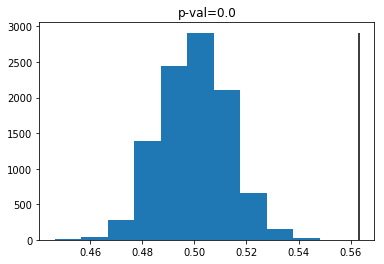

In [136]:
f_measure_random = [f1_score(list(testset_clase), random.sample(list(testset_clase), len(testset_clase)), average="macro") for i in range(10000)]
# Histograma
histograma = plt.hist(f_measure_random)
plt.vlines(MNB_score,ymin=0,ymax=histograma[0].max())
plt.title("p-val="+str((f_measure_random>MNB_score).sum()/len(f_measure_random)))

### Construyo un clasificador Random Forest

In [137]:
clf_RF = RandomForestClassifier(class_weight="balanced",random_state=123)
# Parametros a variar 
parameters = {'n_estimators':[200],'max_features': [10,20,'auto'],"max_depth":[5,10,None] }
# define un grid search a realizar 
grid_search_RF = GridSearchCV(clf_RF, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_RF.fit(trainset_texto_token, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_RF = grid_search_RF.best_estimator_
print ("n_estimators:",best_clf_RF.n_estimators,"; max_features:",best_clf_RF.max_features,"; max_depth:",best_clf_RF.max_depth )
print("fscore_cv=",grid_search_RF.cv_results_["mean_test_score"].max())

n_estimators: 200 ; max_features: 10 ; max_depth: 10
fscore_cv= 0.5604475607388141


### Evalúo el desempeño entre Naive Bayes y Random Forest mediante un histograma

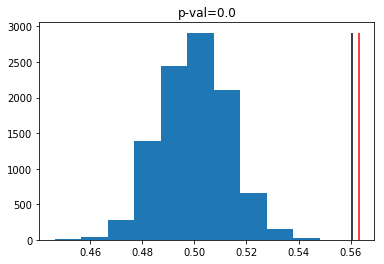

In [138]:
rfscore = grid_search_RF.cv_results_["mean_test_score"].max()
histograma = plt.hist(f_measure_random)
plt.vlines(rfscore,ymin=0,ymax=histograma[0].max()) #En negro Random Forest
plt.title("p-val="+str((f_measure_random>rfscore).sum()/len(f_measure_random)))
plt.vlines(MNB_score,ymin=0,ymax=histograma[0].max(),color="red") #En rojo Naive Bayes

### Grafico las palabras importantes

(array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016]),
 <a list of 9 Text yticklabel objects>)

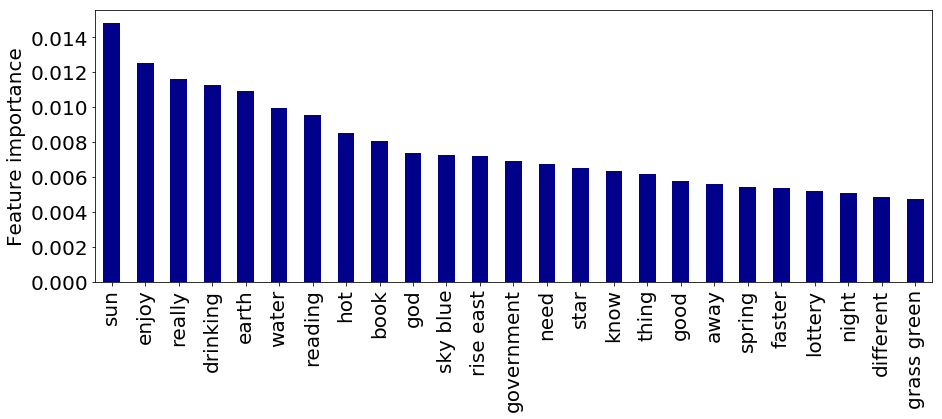

In [139]:
important_words = pd.Series(best_clf_RF.feature_importances_,index=count_vect.get_feature_names()).sort_values(ascending=False)[:25]
important_words.plot(kind="bar",figsize=(15,5),color="darkblue")
plt.ylabel("Feature importance",size=20);plt.xticks(size = 20);plt.yticks(size = 20)
# Es probable que wa y ha sean problema del tokenizador 

### Armo un Pipeline para evaluar usando TF-IDF

In [ ]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer,stop_words="english",ngram_range=(1,2))),
                     ('reduce_dim', SelectKBest(mutual_info_classif)),
                     ('clf',  MultinomialNB())])
    
parameters = {'tfidf__use_idf': [True, False],
              'tfidf__min_df': [3,5,7,10],
              'clf__alpha': [0.001, 0.01,0.1,1,10,100]}

clf_pipe = GridSearchCV(pipeline, parameters, scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)

clf_pipe.fit(trainset_texto, trainset_clase)

best_pipeline = clf_pipe.best_estimator_

#### Evalúo el Pipeline

In [ ]:
print("Best score:",clf_pipe.best_score_)
print("\nBest parameters set:")
best_parameters = best_pipeline.get_params()
print("use idf:",best_parameters["tfidf__use_idf"])
print("RF max_features:",best_parameters["tfidf__min_df"])
print("RF max_depth:",best_parameters["clf__alpha"])